# Data Management Project Code 
                                                                                                by Chiara Genuardi and Giovanni Noè

#### Context
The announce of Oscar awards nominees happened on the 23/01/2025 and the cerimony took place on 02/03/2025

#### Libraries Importation

In [1]:
import requests, json
from pprint import pprint
from bs4 import BeautifulSoup
import pandas as pd
import praw
from praw.models import MoreComments
import time
import pickle
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Acquisition

### 1.1 API Requests

#### TMDB

In [2]:
# Let's perform an HTTP GET request, the response will be a JSON array
response = requests.get("https://api.themoviedb.org/3/discover/movie?primary_release_year=2024", params={'api_key':'40cb487e6ef8163baf6f234a73f3a6f8'})

In [3]:
response.json()

{'page': 1,
 'results': [{'adult': False,
   'backdrop_path': '/9OO6I25MHhCDd0XwNk4oZl0fpwB.jpg',
   'genre_ids': [28, 18],
   'id': 1261050,
   'original_language': 'da',
   'original_title': 'De lydløse',
   'overview': 'In 2008, a group of men from Denmark and across Europe pull off the biggest heist of all time on Danish soil. Kasper, a boxer with few chances left in life, is offered the opportunity to plan the robbery by its foreign initiators.',
   'popularity': 342.887,
   'poster_path': '/7NLY1jNwtZX1yVzwVoBeAhaBE8i.jpg',
   'release_date': '2024-10-31',
   'title': 'The Quiet Ones',
   'video': False,
   'vote_average': 4.8,
   'vote_count': 9},
  {'adult': False,
   'backdrop_path': '/1w8kutrRucTd3wlYyu5QlUDMiG1.jpg',
   'genre_ids': [12, 10751, 16],
   'id': 762509,
   'original_language': 'en',
   'original_title': 'Mufasa: The Lion King',
   'overview': 'Mufasa, a cub lost and alone, meets a sympathetic lion named Taka, the heir to a royal bloodline. The chance meeting set

In [4]:
first_TMDB_data = []
response = requests.get(f"https://api.themoviedb.org/3/discover/movie?primary_release_year=2024&vote_count.gte=25", params={'api_key':'40cb487e6ef8163baf6f234a73f3a6f8'})
npages = response.json()['total_pages']

for k in range(1,npages):
    response = requests.get(f"https://api.themoviedb.org/3/discover/movie?primary_release_year=2024&page={k}&vote_count.gte=24", params={'api_key':'40cb487e6ef8163baf6f234a73f3a6f8'})
    data = response.json()
    # Store the current page of results
    first_TMDB_data = first_TMDB_data + data['results']

In [5]:
IDs = []

for movie in first_TMDB_data:
    IDs.append(movie['id'])

nominated_lost = [1214527, 1195310, 1356881, 1300245, 1108462, 1284874, 1178556, 1118941, 
                  1337997, 1316292, 1279229, 1156619, 1157132, 1249728, 1156605, 1220646]

IDs = IDs + nominated_lost

In [6]:
TMDB_data = []
for ID in IDs:
    response = requests.get(f"https://api.themoviedb.org/3/movie/{ID}", params={'api_key':'40cb487e6ef8163baf6f234a73f3a6f8'})
    TMDB_data.append(response.json())

print("We have", len(TMDB_data), "total results from TMDB")

We have 976 total results from TMDB


#### OMDB

In [7]:
# Let's perform an HTTP GET request, the response will be a JSON array
response = requests.get("http://www.omdbapi.com/", params={'t':'Anora', 'apikey':'177bf46c'})
pprint(response.json())

{'Actors': 'Mikey Madison, Paul Weissman, Yura Borisov',
 'Awards': 'Won 5 Oscars. 144 wins & 267 nominations total',
 'BoxOffice': '$16,300,129',
 'Country': 'United States',
 'DVD': 'N/A',
 'Director': 'Sean Baker',
 'Genre': 'Comedy, Drama, Romance',
 'Language': 'English, Russian, Armenian',
 'Metascore': '91',
 'Plot': 'A young escort from Brooklyn meets and impulsively marries the son '
         'of a Russian oligarch. Once the news reaches Russia, her fairy tale '
         'is threatened as his parents set out for New York to get the '
         'marriage annulled.',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BYThiN2M0NTItODRmNC00NDhlLWFiYTgtMWM2YTEyYzI3ZTY1XkEyXkFqcGc@._V1_SX300.jpg',
 'Production': 'N/A',
 'Rated': 'R',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '7.8/10'},
             {'Source': 'Rotten Tomatoes', 'Value': '93%'},
             {'Source': 'Metacritic', 'Value': '91/100'}],
 'Released': '08 Nov 2024',
 'Response': 'True',
 'Runtime': '13

In [8]:
OMDB_data = []
OMDB_not_found = []
print(f'Performing requests...')

for movie in TMDB_data:
    response = requests.get("http://www.omdbapi.com/", params={'i':movie['imdb_id'], 'apikey':'177bf46c'})
    film = response.json()
    
    if film['Response'] == 'True':
        OMDB_data.append(response.json())
        
    else: OMDB_not_found.append(movie['title'])
        
print(f'{len(OMDB_not_found)} titles from TMDB_data were not found in OMDB, titles are stored in OMDB_not_found')
print(f'We have {len(OMDB_data)} total results from OMDB')

Performing requests...
7 titles from TMDB_data were not found in OMDB, titles are stored in OMDB_not_found
We have 969 total results from OMDB


In [9]:
OMDB_not_found #Some appear in OMDB with different titles or have None imdb_id in TMDB but they are all not very relevant titles

['Squid Game: Fireplace',
 'My Cousin the Sexologist 2',
 'Familia',
 'Return of the King: The Fall and Rise of Elvis Presley',
 'WWE WrestleMania XL Sunday',
 'Paris 2024 Olympic Opening Ceremony',
 'Florence Foresti : Boys Boys Boys']

#### Reddit

In [10]:
reddit = praw.Reddit(
    client_id="gBxaC3Dksg80bXSA9tl_Cw",
    client_secret="2uvAIn0GPQyVT56uuxXosTSonJpd4g",
    user_agent="My script for Data Management Project v2.0 - by Chiara and Giovanni")

In [11]:
#Select submissions
submissions = []
submissions.append(reddit.submission(id="1i836g7")) # 2025 Oscar Nominations: Full List of Nominees News (from r/movies)
submissions.append(reddit.submission(id="1j24nvr")) # The 97th Annual Academy Awards Official Discussion Thread (from r/Oscars)
submissions.append(reddit.submission(id="1j1xpis")) # 2025 Oscars Megathread (from r/popculturechat)


In [12]:
def comments_replace(submission):
    t0 = time.time()
    
    while True:
        try:
            print('\tReplacing MoreComments...')
            submission.comments.replace_more(limit=None)
            break
        except Exception:
            print("\tHandling Exeption...")
            time.sleep(2)
            
    t1 = time.time()
    print(f'\tReplacing completed in {round((t1-t0)/60,2)} minutes')

In [13]:
def comments_append(submission, comments):
    print('\tAppending to comments...')
    
    for comment in submission.comments.list():
        
        if isinstance(comment, MoreComments):
            continue
            
        comments.append(comment.body)

In [ ]:
#Taking comments from selected submissions
comments=[]
i = 1
for submission in submissions:
    
    print (f'Executing request number {i}:')
    comments_replace(submission)
    comments_append(submission, comments)
    i = i+1
    
print(f'Total number of comments found: {len(comments)}')

In [ ]:
#Save pickle 
#Last executed on 12/03/2025 ----------------------- 15/03/2025
with open("reddit_comments.pkl", "wb") as f:
    pickle.dump(comments, f)

### 1.2 Web Scraping

#### Wikipedia - 97th Academy Awards (Oscars)

In [14]:
base_url = "https://en.wikipedia.org/wiki/97th_Academy_Awards"
response = requests.get(base_url)
html_page = response.text
html_tree = BeautifulSoup(html_page, "html.parser")

In [15]:
oscarsDB = []
award_pp = ['Best Directing', 'Best Actor in a Leading Role', 'Best Actress in a Leading Role',
       'Best Actor in a Supporting Role', 'Best Actress in a Supporting Role']
table = html_tree.find("table", class_="wikitable", role="presentation")
tds = table.find_all("td")

for td in tds:
    a = td.find("div").find("a")
    award = a.text
    ul = td.find("ul")

    winner_dict = {"award":award, "winner":True, "title":ul.find("i").find("a").text}
    
    if award in award_pp:
        winner_dict["person"] = ul.find("a").text    
        
    oscarsDB.append(winner_dict)
    
    lis = ul.find("ul").find_all("li")
    for li in lis:
        film_dict = {"award":award, "winner":False}
        a = li.find("i").find("a")
        if not a:
            a = li.find("i")
        film_dict["title"] = a.text

        if award in award_pp:
            b = li.find("a")
            film_dict["person"] = b.text
            
        oscarsDB.append(film_dict)

## 2. Data Modelling

#### TMDB

In [16]:
TMDB_df = pd.DataFrame(TMDB_data)

#### OMDB

In [17]:
OMDB_df = pd.DataFrame(OMDB_data)

#### Oscars

In [18]:
oscars_df = pd.DataFrame(oscarsDB)

## 3. Data Processing

#### TMDB_df

In [19]:
TMDB_df.head(1)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,original_language,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,/1w8kutrRucTd3wlYyu5QlUDMiG1.jpg,"{'id': 762512, 'name': 'The Lion King (Reboot)...",200000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",https://movies.disney.com/mufasa-the-lion-king,762509,tt13186482,[US],en,...,2024-12-18,717197856,118,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The story of an orphan who would be king.,Mufasa: The Lion King,False,7.449,1799


In [20]:
TMDB_df.dtypes

adult                       bool
backdrop_path             object
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
id                         int64
imdb_id                   object
origin_country            object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                    int64
runtime                    int64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                       bool
vote_average             float64
vote_count                 int64
dtype: object

In [21]:
#Deleting non useful variables from TMDB_df
TMDB_df.drop(columns = ['adult', 'backdrop_path', 'belongs_to_collection', 'genres', 'id', 
                                  'production_companies', 'production_countries', 'poster_path', 
                                  'video', 'spoken_languages', 'status', 'tagline'], inplace=True)

In [22]:
#Replace N/A values with type nan of pandas
TMDB_df.replace('N/A', np.nan, inplace = True)

In [23]:
TMDB_df[['budget', 'revenue']] = TMDB_df[['budget', 'revenue']].replace(0, np.nan)

In [24]:
TMDB_df.dtypes

budget               float64
homepage              object
imdb_id               object
origin_country        object
original_language     object
original_title        object
overview              object
popularity           float64
release_date          object
revenue              float64
runtime                int64
title                 object
vote_average         float64
vote_count             int64
dtype: object

In [25]:
#Convert release date to format date time
TMDB_df['release_date'] = pd.to_datetime(TMDB_df['release_date'])

In [26]:
#Rearrange columns
TMDB_df = TMDB_df[['title', 'original_title', 'imdb_id', 'runtime', 'original_language', 'origin_country', 'overview', 'release_date', 
                   'homepage', 'budget', 'revenue', 'vote_average', 'vote_count', 'popularity']]

In [27]:
#Modify column names accordingly
TMDB_df = TMDB_df.rename(columns = {'vote_average' : 'tmdbRating', 'vote_count' : 'tmdbVotes', 
                                    'original_title' : 'originalTitle', 'original_language' : 'originalLanguage', 
                                    'overview' : 'plot', 'release_date' : 'releaseDate', 'imdb_id' : 'imdbID',
                                    'origin_country' : 'originCountry'})

In [28]:
TMDB_df.head()

,title,originalTitle,imdbID,runtime,originalLanguage,originCountry,plot,releaseDate,homepage,budget,revenue,tmdbRating,tmdbVotes,popularity
0,Mufasa: The Lion King,Mufasa: The Lion King,tt13186482,118,en,[US],"Mufasa, a cub lost and alone, meets a sympathe...",2024-12-18,https://movies.disney.com/mufasa-the-lion-king,200000000.0,7.171979e+08,7.449,1799,238.3487
1,Moana 2,Moana 2,tt13622970,99,en,[US],After receiving an unexpected call from her wa...,2024-11-21,https://movies.disney.com/moana-2,150000000.0,1.056397e+09,7.100,2097,220.0556
2,Sonic the Hedgehog 3,Sonic the Hedgehog 3,tt18259086,110,en,[US],"Sonic, Knuckles, and Tails reunite against a p...",2024-12-19,https://www.sonicthehedgehogmovie.com,122000000.0,4.860185e+08,7.800,2298,150.0364
3,Old Guy,Old Guy,tt26442053,93,en,[US],Stuck at a dead end but vying for the love of ...,2024-12-13,https://theavenue.film/movies/old-guy,NaN,NaN,5.516,61,128.2014
4,Hellhound,Hellhound,tt22489042,103,en,[TH],"Ready to leave his profession behind, Loreno, ...",2024-06-20,https://hellhoundthemovie.com/,1100000.0,NaN,6.468,31,117.1079


#### OMDB_df

In [29]:
OMDB_df.head(1)

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,imdbID,Type,DVD,BoxOffice,Production,Website,Response,Season,Episode,seriesID
0,Mufasa: The Lion King,2024,PG,20 Dec 2024,118 min,"Animation, Adventure, Drama",Barry Jenkins,Jeff Nathanson,"Aaron Pierre, Kelvin Harrison Jr., Tiffany Boone","Mufasa, a cub lost and alone, meets a sympathe...",...,tt13186482,movie,N/A,"$248,443,645",N/A,N/A,True,NaN,NaN,NaN


In [30]:
OMDB_df.dtypes

Title         object
Year          object
Rated         object
Released      object
Runtime       object
Genre         object
Director      object
Writer        object
Actors        object
Plot          object
Language      object
Country       object
Awards        object
Poster        object
Ratings       object
Metascore     object
imdbRating    object
imdbVotes     object
imdbID        object
Type          object
DVD           object
BoxOffice     object
Production    object
Website       object
Response      object
Season        object
Episode       object
seriesID      object
dtype: object

In [31]:
OMDB_df['Ratings'][0]

[{'Source': 'Internet Movie Database', 'Value': '6.6/10'},
 {'Source': 'Rotten Tomatoes', 'Value': '57%'},
 {'Source': 'Metacritic', 'Value': '56/100'}]

In [32]:
#Get ratings of rotten tomatoes from 'ratings'
def get_rotten_tomatoes(row):
    rotten_rating = np.nan
    for source in row['Ratings']:
        if source['Source'] == 'Rotten Tomatoes':
            rotten_rating = (float(source['Value'].rstrip("%"))/10)
    return rotten_rating

OMDB_df['rottenTomatoesRating'] = OMDB_df.apply(get_rotten_tomatoes,axis=1)

In [33]:
#Deleting non useful variables from OMDB_df
OMDB_df.drop(columns = ['Year', 'Runtime', 'Released', 'Writer', 'Plot', 'Language', 'Country', 'Poster', 'Ratings', 'DVD', 
                                  'Type', 'BoxOffice', 'Production', 'Website', 'Response', 'Season', 'Episode', 'seriesID'], inplace = True)

In [34]:
#Replace N/A values with type nan of pandas
OMDB_df.replace('N/A', np.nan, inplace = True)

In [35]:
OMDB_df.dtypes

Title                    object
Rated                    object
Genre                    object
Director                 object
Actors                   object
Awards                   object
Metascore                object
imdbRating               object
imdbVotes                object
imdbID                   object
rottenTomatoesRating    float64
dtype: object

In [36]:
#Converting objects to numeric
OMDB_df['imdbRating'] = OMDB_df['imdbRating'].astype(float)

OMDB_df['imdbVotes'] = OMDB_df['imdbVotes'].replace(r',', '', regex=True).astype(float)

OMDB_df['Metascore'] = OMDB_df['Metascore'].astype(float)

In [37]:
#Change range of 'Metascore' from 0-100 to 0-10
OMDB_df['Metascore'] = OMDB_df['Metascore'] / 10

In [38]:
#Transforming 'Genre' into a list
OMDB_df['Genre'] = OMDB_df['Genre'].str.split(', ')

In [39]:
OMDB_df['Rated'] = OMDB_df['Rated'].apply(lambda x: 'Unrated' if x == 'Not Rated' else x)

In [40]:
#OMDB_df.replace({'Rated' : {'Not Rated':'Unrated'}}, inplace = True)

In [41]:
#Rearrange columns
OMDB_df = OMDB_df[['Title', 'imdbID', 'Director', 'Actors', 'Awards', 'imdbVotes',
                   'imdbRating', 'Metascore', 'rottenTomatoesRating', 'Rated', 'Genre']]

In [42]:
#Modify column names accordingly
OMDB_df = OMDB_df.rename(columns = {'Title' : 'title', 'Director' : 'director', 'Actors' : 'actors',
                                    'Awards' : 'awards', 'Metascore' : 'metacriticRating',
                                   'Rated' : 'mpaFilmRating', 'Genre' : 'genre'})

In [43]:
OMDB_df.head()

,title,imdbID,director,actors,awards,imdbVotes,imdbRating,metacriticRating,rottenTomatoesRating,mpaFilmRating,genre
0,Mufasa: The Lion King,tt13186482,Barry Jenkins,"Aaron Pierre, Kelvin Harrison Jr., Tiffany Boone",15 nominations total,44872.0,6.6,5.6,5.7,PG,"[Animation, Adventure, Drama]"
1,Moana 2,tt13622970,"David G. Derrick Jr., Jason Hand, Dana Ledoux ...","Auli'i Cravalho, Dwayne Johnson, Hualalai Chung",2 wins & 25 nominations total,88419.0,6.7,5.8,6.1,PG,"[Animation, Adventure, Comedy]"
2,Sonic the Hedgehog 3,tt18259086,Jeff Fowler,"Jim Carrey, Ben Schwartz, Keanu Reeves",1 nomination total,52320.0,6.9,5.6,8.5,PG,"[Action, Adventure, Comedy]"
3,Old Guy,tt26442053,Simon West,"Christoph Waltz, Lucy Liu, Cooper Hoffman",NaN,1748.0,5.1,3.3,2.9,R,"[Action, Comedy]"
4,Hellhound,tt22489042,Joshua Dixon,"Sahajak Boonthanakit, Ross James Cain, Tanapol...",NaN,446.0,4.3,NaN,NaN,R,"[Action, Crime, Thriller]"


### Reddit

In [44]:
#Open pickle
with open("reddit_comments.pkl", "rb") as f:
    comments_loaded = pickle.load(f)

In [45]:
oscars_df.head()

,award,winner,title,person
0,Best Picture,True,Anora,NaN
1,Best Picture,False,The Brutalist,NaN
2,Best Picture,False,A Complete Unknown,NaN
3,Best Picture,False,Conclave,NaN
4,Best Picture,False,Dune: Part Two,NaN


In [46]:
#Create dictionary to be used on regex - here we add for every film its title
word_dict = {}
for title in oscars_df['title'].unique():
    word_dict[title] = [title]

In [47]:
#Add in dictionary name of actors and directors from OMDB_db
oscars_OMDB = OMDB_df[OMDB_df['title'].isin(list(oscars_df['title']))]
for _,row in oscars_OMDB.iterrows():
    actors = row['actors']
    if actors is not np.nan:
        word_dict[row['title']] += actors.split(', ')
    directors = row['director']
    if directors is not np.nan:
        for director in directors.split(', '):
            if director not in word_dict[row['title']]:
                word_dict[row['title']].append(director)

In [48]:
#If we have some people in oscars_df not present in the dictionary, insert them
for _,row in oscars_df.iterrows():
    person = row['person']
    if (person not in word_dict[row['title']]) & (person is not np.nan):
        word_dict[row['title']].append(person)

In [49]:
#Add original title if not already in dictionary
oscars_TMDB = TMDB_df[TMDB_df['title'].isin(list(oscars_df['title']))]
for _,row in oscars_TMDB.iterrows():
    original_title = row['originalTitle']
    if (original_title not in word_dict[row['title']]):
        word_dict[row['title']].append(original_title)

In [50]:
for movie in word_dict:
    print(f'word_dict["{movie}"] += []')

word_dict["Anora"] += []
word_dict["The Brutalist"] += []
word_dict["A Complete Unknown"] += []
word_dict["Conclave"] += []
word_dict["Dune: Part Two"] += []
word_dict["Emilia Pérez"] += []
word_dict["I'm Still Here"] += []
word_dict["Nickel Boys"] += []
word_dict["The Substance"] += []
word_dict["Wicked"] += []
word_dict["Sing Sing"] += []
word_dict["The Apprentice"] += []
word_dict["A Real Pain"] += []
word_dict["September 5"] += []
word_dict["Flow"] += []
word_dict["Inside Out 2"] += []
word_dict["Memoir of a Snail"] += []
word_dict["Wallace & Gromit: Vengeance Most Fowl"] += []
word_dict["The Wild Robot"] += []
word_dict["The Girl with the Needle"] += []
word_dict["The Seed of the Sacred Fig"] += []
word_dict["No Other Land"] += []
word_dict["Black Box Diaries"] += []
word_dict["Porcelain War"] += []
word_dict["Soundtrack to a Coup d'Etat"] += []
word_dict["Sugarcane"] += []
word_dict["The Only Girl in the Orchestra"] += []
word_dict["Death by Numbers"] += []
word_dict["I Am Ready,

In [51]:
#Add by hand some other relevant words for every film
word_dict["Anora"] += ['Ani', 'Mikey', 'Madison','Sean','Baker']
word_dict["The Brutalist"] += ['Brutalist', 'Brady', 'Corbet','Adrien','Brody']
word_dict["A Complete Unknown"] += ['Complete Unknown']
word_dict["Conclave"] += []
word_dict["Dune: Part Two"] += ['Dune']
word_dict["Emilia Pérez"] += ['Emilia', 'Pèrez', 'Pérez', 'Perez']
word_dict["I'm Still Here"] += ['Im Still Here', 'am Still Here', 'Still Here']
word_dict["Nickel Boys"] += ['Nickel Boys', 'Nickel', 'Nicel Boys', 'Nikel Boys']
word_dict["The Substance"] += ['Substance']
word_dict["Wicked"] += ['Ariana', 'Cynthia']
word_dict["Sing Sing"] += []
word_dict["The Apprentice"] += ['Apprentice', 'Trump']
word_dict["A Real Pain"] += ['Real Pain']
word_dict["September 5"] += []
word_dict["Flow"] += ['Latvia']
word_dict["Inside Out 2"] += ['Inside Out']
word_dict["Memoir of a Snail"] += ['Snail']
word_dict["Wallace & Gromit: Vengeance Most Fowl"] += ['Wallace & Gromit', 'Wallace and Gromit']
word_dict["The Wild Robot"] += ['Wild Robot']
word_dict["The Girl with the Needle"] += ['Girl with the Needle', 'Girl with Needle']
word_dict["The Seed of the Sacred Fig"] += ['Sacred Fig']
word_dict["No Other Land"] += ['Other Land']
word_dict["Black Box Diaries"] += ['Black Box', 'Black Diaries', 'Box Diaries']
word_dict["Porcelain War"] += ['Porcelain']
word_dict["Soundtrack to a Coup d'Etat"] += ["Coup d'Etat", 'Coup dEtat', 'Coup Etat']
word_dict["Sugarcane"] += []
word_dict["The Only Girl in the Orchestra"] += ['Girl in the Orchestra','Girl Orchestra', 'Girl in Orchestra']
word_dict["Death by Numbers"] += ['Death Numbers']
word_dict["I Am Ready, Warden"] += ['Warden']
word_dict["Incident"] += []
word_dict["Instruments of a Beating Heart"] += ['Beating Heart']
word_dict["I'm Not a Robot"] += ['Not a Robot']
word_dict["A Lien"] += ['Lien']
word_dict["Anuja"] += ['Anuia']
word_dict["The Last Ranger"] += ['Last Ranger']
word_dict["The Man Who Could Not Remain Silent"] += ["The Man Who Couldn't Remain Silent"]
word_dict["In the Shadow of the Cypress"] += ['Cypress']
word_dict["Beautiful Men"] += []
word_dict["Magic Candies"] += []
word_dict["Wander to Wonder"] += []
word_dict["Yuck!"] += ['Yuck']
word_dict["The Six Triple Eight"] += ['Triple Six Eigth', 'Triple Eigth']
word_dict["Elton John: Never Too Late"] += ['Elton']
word_dict["Nosferatu"] += ['Lily Rose', 'Lily-Rose', 'Dafoe']
word_dict["Maria"] += []
word_dict["A Different Man"] += ['Different Man']
word_dict["Gladiator II"] += ['Gladiator']
word_dict["Alien: Romulus"] += ['Alien','Romulus']
word_dict["Better Man"] += ['Better Men']
word_dict["Kingdom of the Planet of the Apes"] += ['Apes']

In [52]:
word_dict

{'Anora': ['Anora',
  'Mikey Madison',
  'Paul Weissman',
  'Yura Borisov',
  'Sean Baker',
  'Ani',
  'Mikey',
  'Madison',
  'Sean',
  'Baker'],
 'The Brutalist': ['The Brutalist',
  'Adrien Brody',
  'Felicity Jones',
  'Guy Pearce',
  'Brady Corbet',
  'Brutalist',
  'Brady',
  'Corbet',
  'Adrien',
  'Brody'],
 'A Complete Unknown': ['A Complete Unknown',
  'Timothée Chalamet',
  'Edward Norton',
  'Elle Fanning',
  'James Mangold',
  'Monica Barbaro',
  'Complete Unknown'],
 'Conclave': ['Conclave',
  'Ralph Fiennes',
  'Stanley Tucci',
  'John Lithgow',
  'Edward Berger',
  'Isabella Rossellini'],
 'Dune: Part Two': ['Dune: Part Two',
  'Timothée Chalamet',
  'Zendaya',
  'Rebecca Ferguson',
  'Denis Villeneuve',
  'Dune'],
 'Emilia Pérez': ['Emilia Pérez',
  'Zoe Saldaña',
  'Karla Sofía Gascón',
  'Selena Gomez',
  'Jacques Audiard',
  'Emilia',
  'Pèrez',
  'Pérez',
  'Perez'],
 "I'm Still Here": ["I'm Still Here",
  'Fernanda Torres',
  'Fernanda Montenegro',
  'Selton Mello

In [53]:
#Count how many times words related to a certain film appear in saved comments from reddit
count_data = []
for title in oscars_df['title'].unique():
    count_data.append({'title':title,'mentionsCount':0})

for comment in comments_loaded:
    for movie in count_data:
        title = movie['title']
        regex = "("
        word_list = word_dict[title]
        l = len(word_list)
        for word in word_list:
            if word == word_list[len(word_list)-1]:
                regex += f"\\b{word}\\b)"
            else:
                regex += f"\\b{word}\\b|"
        try:
            if re.search(regex, comment, re.IGNORECASE):
                movie['mentionsCount'] = movie['mentionsCount'] + 1
        except:
            print(regex)

In [54]:
counts_df = pd.DataFrame(count_data)

In [55]:
#Add imdbID 
for index, row in TMDB_df.iterrows():
    if row['title'] in counts_df['title'].values:
        ind = counts_df.index[counts_df['title'] == row['title']]
        counts_df.loc[ind,'imdbID'] = row['imdbID']

In [56]:
counts_df

,title,mentionsCount,imdbID
0,Anora,1449,tt28607951
1,The Brutalist,848,tt8999762
2,A Complete Unknown,118,tt11563598
3,Conclave,376,tt20215234
4,Dune: Part Two,644,tt15239678
5,Emilia Pérez,975,tt20221436
6,I'm Still Here,181,tt14961016
7,Nickel Boys,76,tt23055660
8,The Substance,690,tt17526714
9,Wicked,898,tt1262426


### Oscars

In [57]:
#Add imdbID
for index, row in TMDB_df.iterrows():
    if row['title'] in oscars_df['title'].values:
        ind = oscars_df.index[oscars_df['title'] == row['title']]
        oscars_df.loc[ind,'imdbID'] = row['imdbID']

In [58]:
oscars_df

,award,winner,title,person,imdbID
0,Best Picture,True,Anora,NaN,tt28607951
1,Best Picture,False,The Brutalist,NaN,tt8999762
2,Best Picture,False,A Complete Unknown,NaN,tt11563598
3,Best Picture,False,Conclave,NaN,tt20215234
4,Best Picture,False,Dune: Part Two,NaN,tt15239678
...,...,...,...,...,...
115,Best Visual Effects,True,Dune: Part Two,NaN,tt15239678
116,Best Visual Effects,False,Alien: Romulus,NaN,tt18412256
117,Best Visual Effects,False,Better Man,NaN,tt14260836
118,Best Visual Effects,False,Kingdom of the Planet of the Apes,NaN,tt11389872


## 4. Data Quality Assessment - Before Integration and Enrichment

### 4.1 Accuracy

In [59]:
#Check for missing values
TMDB_df.isnull().sum()

title                 0
originalTitle         0
imdbID                1
runtime               0
originalLanguage      0
originCountry         0
plot                  0
releaseDate           0
homepage              0
budget              728
revenue             625
tmdbRating            0
tmdbVotes             0
popularity            0
dtype: int64

In [60]:
#Show rows in which we have some missing values
TMDB_df[TMDB_df.isnull().any(axis=1)]

,title,originalTitle,imdbID,runtime,originalLanguage,originCountry,plot,releaseDate,homepage,budget,revenue,tmdbRating,tmdbVotes,popularity
3,Old Guy,Old Guy,tt26442053,93,en,[US],Stuck at a dead end but vying for the love of ...,2024-12-13,https://theavenue.film/movies/old-guy,NaN,NaN,5.516,61,128.2014
4,Hellhound,Hellhound,tt22489042,103,en,[TH],"Ready to leave his profession behind, Loreno, ...",2024-06-20,https://hellhoundthemovie.com/,1100000.0,NaN,6.468,31,117.1079
5,"I, the Executioner",베테랑 2,tt30287778,118,ko,[KR],The veteran detective Seo Do-cheol and his tea...,2024-09-13,,NaN,53453611.0,7.000,45,92.6976
7,Amaran,அமரன்,tt27118357,169,ta,[IN],A heroic true story of Major Mukund Varadaraja...,2024-10-31,,21000000.0,NaN,7.400,197,97.6612
11,Solo Leveling -ReAwakening-,俺だけレベルアップな件 -ReAwakening-,tt33428606,116,ja,[JP],Over a decade after 'gates' connecting worlds ...,2024-11-26,https://www.sololevelingreawakening.com,NaN,6331827.0,6.900,176,79.2416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,In the Shadow of the Cypress,در سایه سرو,tt28768883,19,xx,[IR],"A former captain, suffering from post-traumati...",2023-09-07,,NaN,NaN,6.100,16,0.3925
972,Beautiful Men,Beautiful Men,tt30835281,19,nl,"[BE, FR, NL]",Three balding brothers travel to Istanbul to g...,2023-10-14,,NaN,NaN,5.500,11,0.2981
973,Magic Candies,あめだま,tt31888603,21,ja,[JP],"The other kids never ask Dong-Dong to play, bu...",2025-02-28,,NaN,NaN,6.000,6,0.2447
974,Wander to Wonder,Wander to Wonder,tt28768679,14,en,"[BE, FR, NL, GB]","In the 1980s, Mary, Billybud, and Fumbleton st...",2024-09-12,,NaN,NaN,6.667,15,0.2738


In [61]:
OMDB_df.isnull().sum()

title                     0
imdbID                    0
director                  3
actors                   11
awards                  459
imdbVotes                25
imdbRating              140
metacriticRating        641
rottenTomatoesRating    420
mpaFilmRating           436
genre                     1
dtype: int64

### 4.2 Minimality

In [62]:
#Check for duplicates
duplicates_TMDB = {}

for _, row in TMDB_df.iterrows():
    key = (row['title'], row['imdbID'])
    
    if key in duplicates_TMDB:
        duplicates_TMDB[key] += 1 
    else:
        duplicates_TMDB[key] = 1  

for key, count in duplicates_TMDB.items():
    if count >= 2:
        print(f"Film {key}: appears {count} times")

Film ('Anuja', 'tt27654431'): appears 2 times


In [63]:
duplicates_OMDB = {}

for _, row in OMDB_df.iterrows():
    key = (row['title'], row['imdbID'])
    
    if key in duplicates_OMDB:
        duplicates_OMDB[key] += 1 
    else:
        duplicates_OMDB[key] = 1  

for key, count in duplicates_OMDB.items():
    if count >= 2:
        print(f"Film {key}: appears {count} times")

Film ('Anuja', 'tt27654431'): appears 2 times


### 4.3 Consistency

In [64]:
#Check if we have improbable values in TMDB
print(f"Runtime spans from {TMDB_df['runtime'].min(numeric_only=True)} to {TMDB_df['runtime'].max(numeric_only=True)}")
print(f"Budget spans from {TMDB_df['budget'].min(numeric_only=True)} to {TMDB_df['budget'].max(numeric_only=True)}")
print(f"Revenue spans from {TMDB_df['revenue'].min(numeric_only=True)} to {TMDB_df['revenue'].max(numeric_only=True)}")
print(f"Rating in TMDB spans from {TMDB_df['tmdbRating'].min(numeric_only=True)} to {TMDB_df['tmdbRating'].max(numeric_only=True)}")
print(f"Votes from TMDB spans from {TMDB_df['tmdbVotes'].min(numeric_only=True)} to {TMDB_df['tmdbVotes'].max(numeric_only=True)}")
print(f"Popularity index spans from {TMDB_df['popularity'].min(numeric_only=True)} to {TMDB_df['popularity'].max(numeric_only=True)}")

Runtime spans from 0 to 247
Budget spans from 4.0 to 310000000.0
Revenue spans from 2.0 to 1698863816.0
Rating in TMDB spans from 3.8 to 9.0
Votes from TMDB spans from 4 to 6968
Popularity index spans from 0.1018 to 238.3487


In [65]:
#Check if we have improbable values in OMDB
print(f"Votes from IMDB spans from {OMDB_df['imdbVotes'].min(numeric_only=True)} to {OMDB_df['imdbVotes'].max(numeric_only=True)}")
print(f"Rating in IMDB spans from {OMDB_df['imdbRating'].min(numeric_only=True)} to {OMDB_df['imdbRating'].max(numeric_only=True)}")
print(f"Rating in metacritic spans from {OMDB_df['metacriticRating'].min(numeric_only=True)} to {OMDB_df['metacriticRating'].max(numeric_only=True)}")
print(f"Rating in rotten tomatoes spans from {OMDB_df['rottenTomatoesRating'].min(numeric_only=True)} to {OMDB_df['rottenTomatoesRating'].max(numeric_only=True)}")

Votes from IMDB spans from 5.0 to 610371.0
Rating in IMDB spans from 2.5 to 9.3
Rating in metacritic spans from 2.2 to 9.4
Rating in rotten tomatoes spans from 0.0 to 10.0


### 4.4 Completeness

In [66]:
#Check if nominee film appear in TMDB and OMDB; for those who appear count if we have missing values
nominee_not_in_TMDB = []
nominee_not_in_OMDB = []
count_TMDB = {}
count_OMDB = {}

for film in oscars_df['title'].unique():
    
    if film in TMDB_df['title'].tolist():
        count_TMDB[film] = TMDB_df[TMDB_df['title']==film].isnull().sum()        
    else: 
        nominee_not_in_TMDB.append(film)
        
    if film in OMDB_df['title'].tolist():
        count_OMDB[film] = OMDB_df[OMDB_df['title']==film].isnull().sum()
    else: 
        nominee_not_in_OMDB.append(film)

In [67]:
nominee_not_in_TMDB

[]

In [68]:
nominee_not_in_OMDB

['I Am Ready, Warden', 'Yuck!']

In [69]:
#Check if film which doesn't appear in OMDB have won some oscars
for film in nominee_not_in_OMDB:
    print(oscars_df[oscars_df['title'] == film])

                          award  winner               title person      imdbID
62  Best Documentary Short Film   False  I Am Ready, Warden    NaN  tt31556921
                       award  winner  title person      imdbID
74  Best Animated Short Film   False  Yuck!    NaN  tt28356173


In [70]:
pd.DataFrame(count_TMDB).sum()

Anora                                    0
The Brutalist                            0
A Complete Unknown                       0
Conclave                                 0
Dune: Part Two                           0
Emilia Pérez                             0
I'm Still Here                           0
Nickel Boys                              0
The Substance                            0
Wicked                                   0
Sing Sing                                0
The Apprentice                           0
A Real Pain                              0
September 5                              1
Flow                                     0
Inside Out 2                             0
Memoir of a Snail                        0
Wallace & Gromit: Vengeance Most Fowl    1
The Wild Robot                           0
The Girl with the Needle                 1
The Seed of the Sacred Fig               1
No Other Land                            1
Black Box Diaries                        2
Porcelain W

In [71]:
pd.DataFrame(count_OMDB).sum()

Anora                                     0
The Brutalist                             0
A Complete Unknown                        0
Conclave                                  0
Dune: Part Two                            0
Emilia Pérez                              1
I'm Still Here                            1
Nickel Boys                               0
The Substance                             0
Wicked                                    0
Sing Sing                                 0
The Apprentice                            0
A Real Pain                               0
September 5                               0
Flow                                      1
Inside Out 2                              0
Memoir of a Snail                         0
Wallace & Gromit: Vengeance Most Fowl     0
The Wild Robot                            0
The Girl with the Needle                  0
The Seed of the Sacred Fig                0
No Other Land                             1
Black Box Diaries               

## 5. Data Enrichment

In [72]:
#Merge TMDB and OMDB
movies_DB = TMDB_df.merge(OMDB_df.drop(columns = ['title']), on= 'imdbID', how='left')

In [73]:
movies_DB.shape

(978, 23)

In [74]:
movies_DB.columns

Index(['title', 'originalTitle', 'imdbID', 'runtime', 'originalLanguage',
       'originCountry', 'plot', 'releaseDate', 'homepage', 'budget', 'revenue',
       'tmdbRating', 'tmdbVotes', 'popularity', 'director', 'actors', 'awards',
       'imdbVotes', 'imdbRating', 'metacriticRating', 'rottenTomatoesRating',
       'mpaFilmRating', 'genre'],
      dtype='object')

In [75]:
movies_DB.head()

,title,originalTitle,imdbID,runtime,originalLanguage,originCountry,plot,releaseDate,homepage,budget,...,popularity,director,actors,awards,imdbVotes,imdbRating,metacriticRating,rottenTomatoesRating,mpaFilmRating,genre
0,Mufasa: The Lion King,Mufasa: The Lion King,tt13186482,118,en,[US],"Mufasa, a cub lost and alone, meets a sympathe...",2024-12-18,https://movies.disney.com/mufasa-the-lion-king,200000000.0,...,238.3487,Barry Jenkins,"Aaron Pierre, Kelvin Harrison Jr., Tiffany Boone",15 nominations total,44872.0,6.6,5.6,5.7,PG,"[Animation, Adventure, Drama]"
1,Moana 2,Moana 2,tt13622970,99,en,[US],After receiving an unexpected call from her wa...,2024-11-21,https://movies.disney.com/moana-2,150000000.0,...,220.0556,"David G. Derrick Jr., Jason Hand, Dana Ledoux ...","Auli'i Cravalho, Dwayne Johnson, Hualalai Chung",2 wins & 25 nominations total,88419.0,6.7,5.8,6.1,PG,"[Animation, Adventure, Comedy]"
2,Sonic the Hedgehog 3,Sonic the Hedgehog 3,tt18259086,110,en,[US],"Sonic, Knuckles, and Tails reunite against a p...",2024-12-19,https://www.sonicthehedgehogmovie.com,122000000.0,...,150.0364,Jeff Fowler,"Jim Carrey, Ben Schwartz, Keanu Reeves",1 nomination total,52320.0,6.9,5.6,8.5,PG,"[Action, Adventure, Comedy]"
3,Old Guy,Old Guy,tt26442053,93,en,[US],Stuck at a dead end but vying for the love of ...,2024-12-13,https://theavenue.film/movies/old-guy,NaN,...,128.2014,Simon West,"Christoph Waltz, Lucy Liu, Cooper Hoffman",NaN,1748.0,5.1,3.3,2.9,R,"[Action, Comedy]"
4,Hellhound,Hellhound,tt22489042,103,en,[TH],"Ready to leave his profession behind, Loreno, ...",2024-06-20,https://hellhoundthemovie.com/,1100000.0,...,117.1079,Joshua Dixon,"Sahajak Boonthanakit, Ross James Cain, Tanapol...",NaN,446.0,4.3,NaN,NaN,R,"[Action, Crime, Thriller]"


## 6. Data Quality Improvement

In [76]:
#ACCURACY - Delete rows which have imdbID null; none of them are nominees
movies_DB.drop(movies_DB[movies_DB['imdbID'].isnull()].index, inplace=True)

In [77]:
#MINIMALITY - Delete duplicates
movies_DB.drop_duplicates(subset=['title', 'imdbID'], inplace=True, ignore_index=True)

In [78]:
#COMPLETENESS - Add by hand records for missing nominee films
#I am ready, Warden - Yuck!
movies_DB.loc[movies_DB['title'] == 'Yuck!', 'awards'] = "3 wins & 9 nomination total"
movies_DB.loc[movies_DB['title'] == 'Yuck!', 'imdbVotes'] = 1144
movies_DB.loc[movies_DB['title'] == 'Yuck!', 'imdbRating'] = 6.7

In [79]:
movies_DB.loc[movies_DB['title'] == 'I Am Ready, Warden'].to_dict()

{'title': {962: 'I Am Ready, Warden'},
 'originalTitle': {962: 'I Am Ready, Warden'},
 'imdbID': {962: 'tt31556921'},
 'runtime': {962: 37},
 'originalLanguage': {962: 'en'},
 'originCountry': {962: ['US']},
 'plot': {962: "In the days leading up to his execution, Texas death row prisoner John Henry Ramirez seeks redemption from his victim's son; an elegy about the death penalty where a prisoner seeks forgiveness."},
 'releaseDate': {962: Timestamp('2024-02-21 00:00:00')},
 'homepage': {962: ''},
 'budget': {962: nan},
 'revenue': {962: nan},
 'tmdbRating': {962: 6.3},
 'tmdbVotes': {962: 17},
 'popularity': {962: 2.9449},
 'director': {962: 'Smriti Mundhra'},
 'actors': {962: nan},
 'awards': {962: 'Nominated for 1 Oscar. 1 win & 3 nominations total'},
 'imdbVotes': {962: 321.0},
 'imdbRating': {962: 6.5},
 'metacriticRating': {962: nan},
 'rottenTomatoesRating': {962: nan},
 'mpaFilmRating': {962: nan},
 'genre': {962: ['Documentary', 'Short']}}

## 7. Data Quality Assessment - After Integration and Enrichment

### 7.1 Accuracy

In [80]:
#Check for missing values
movies_DB.isnull().sum()

title                     0
originalTitle             0
imdbID                    0
runtime                   0
originalLanguage          0
originCountry             0
plot                      0
releaseDate               0
homepage                  0
budget                  726
revenue                 623
tmdbRating                0
tmdbVotes                 0
popularity                0
director                  9
actors                   17
awards                  464
imdbVotes                29
imdbRating              144
metacriticRating        646
rottenTomatoesRating    425
mpaFilmRating           441
genre                     7
dtype: int64

### 7.2 Minimality

In [81]:
#Check for duplicates
duplicates_movies = {}

for _, row in movies_DB.iterrows():
    key = (row['title'], row['imdbID'])
    
    if key in duplicates_movies:
        duplicates_movies[key] += 1 
    else:
        duplicates_movies[key] = 1  

for key, count in duplicates_movies.items():
    if count >= 2:
        print(f"Film {key}: appears {count} times")

### 7.3 Consistency

In [82]:
#Check if we have improbable values in TMDB
print(f"Runtime spans from {movies_DB['runtime'].min(numeric_only=True)} to {movies_DB['runtime'].max(numeric_only=True)}")
print(f"Budget spans from {movies_DB['budget'].min(numeric_only=True)} to {movies_DB['budget'].max(numeric_only=True)}")
print(f"Revenue spans from {movies_DB['revenue'].min(numeric_only=True)} to {movies_DB['revenue'].max(numeric_only=True)}")
print(f"Rating in TMDB spans from {movies_DB['tmdbRating'].min(numeric_only=True)} to {movies_DB['tmdbRating'].max(numeric_only=True)}")
print(f"Votes from TMDB spans from {movies_DB['tmdbVotes'].min(numeric_only=True)} to {movies_DB['tmdbVotes'].max(numeric_only=True)}")
print(f"Popularity index spans from {movies_DB['popularity'].min(numeric_only=True)} to {movies_DB['popularity'].max(numeric_only=True)}")
print(f"Votes from IMDB spans from {movies_DB['imdbVotes'].min(numeric_only=True)} to {movies_DB['imdbVotes'].max(numeric_only=True)}")
print(f"Rating in IMDB spans from {movies_DB['imdbRating'].min(numeric_only=True)} to {movies_DB['imdbRating'].max(numeric_only=True)}")
print(f"Rating in metacritic spans from {movies_DB['metacriticRating'].min(numeric_only=True)} to {movies_DB['metacriticRating'].max(numeric_only=True)}")
print(f"Rating in rotten tomatoes spans from {movies_DB['rottenTomatoesRating'].min(numeric_only=True)} to {movies_DB['rottenTomatoesRating'].max(numeric_only=True)}")

Runtime spans from 0 to 247
Budget spans from 4.0 to 310000000.0
Revenue spans from 2.0 to 1698863816.0
Rating in TMDB spans from 3.8 to 9.0
Votes from TMDB spans from 4 to 6968
Popularity index spans from 0.1018 to 238.3487
Votes from IMDB spans from 5.0 to 610371.0
Rating in IMDB spans from 2.5 to 9.3
Rating in metacritic spans from 2.2 to 9.4
Rating in rotten tomatoes spans from 0.0 to 10.0


### 7.4 Completeness

In [83]:
#Check if nominee film appear in TMDB and OMDB; for those who appear count if we have missing values
nominee_not_in_movies = []
count_movies = {}

for film in oscars_df['title'].unique():
    
    if film in movies_DB['title'].tolist():
        count_movies[film] = movies_DB[movies_DB['title']==film].isnull().sum()        
    else: 
        nominee_not_in_movies.append(film)

In [84]:
nominee_not_in_movies

[]

In [85]:
#Check if film which doesn't appear in OMDB have won some oscars
for film in nominee_not_in_movies:
    print(oscars_df[oscars_df['title'] == film])

In [86]:
pd.DataFrame(count_movies).sum()

Anora                                    0
The Brutalist                            0
A Complete Unknown                       0
Conclave                                 0
Dune: Part Two                           0
Emilia Pérez                             1
I'm Still Here                           1
Nickel Boys                              0
The Substance                            0
Wicked                                   0
Sing Sing                                0
The Apprentice                           0
A Real Pain                              0
September 5                              1
Flow                                     1
Inside Out 2                             0
Memoir of a Snail                        0
Wallace & Gromit: Vengeance Most Fowl    1
The Wild Robot                           0
The Girl with the Needle                 1
The Seed of the Sacred Fig               1
No Other Land                            2
Black Box Diaries                        3
Porcelain W

## 8. Data Exploratory Analysis

### 8.1 Statistics

In [87]:
movies_DB.columns

Index(['title', 'originalTitle', 'imdbID', 'runtime', 'originalLanguage',
       'originCountry', 'plot', 'releaseDate', 'homepage', 'budget', 'revenue',
       'tmdbRating', 'tmdbVotes', 'popularity', 'director', 'actors', 'awards',
       'imdbVotes', 'imdbRating', 'metacriticRating', 'rottenTomatoesRating',
       'mpaFilmRating', 'genre'],
      dtype='object')

In [88]:
#Summary statistics of numeric variables
summary_stats = movies_DB[['runtime','budget', 'revenue','tmdbRating', 'tmdbVotes', 'popularity','imdbVotes', 
           'imdbRating', 'metacriticRating', 'rottenTomatoesRating']].describe()
round(summary_stats, 2)

,runtime,budget,revenue,tmdbRating,tmdbVotes,popularity,imdbVotes,imdbRating,metacriticRating,rottenTomatoesRating
count,974.00,2.480000e+02,3.510000e+02,974.00,974.00,974.00,945.00,830.00,328.00,549.00
mean,101.38,3.594541e+07,6.510868e+07,6.51,290.34,7.83,14740.76,6.03,6.04,6.74
std,28.63,4.989331e+07,1.761003e+08,0.77,657.03,17.25,40460.23,1.11,1.56,2.54
min,0.00,4.000000e+00,2.000000e+00,3.80,4.00,0.10,5.00,2.50,2.20,0.00
25%,91.00,6.000000e+06,1.277484e+06,6.00,37.00,1.23,653.00,5.30,4.90,4.80
50%,101.00,1.500000e+07,7.935363e+06,6.60,73.00,2.79,2075.00,6.20,6.10,7.40
75%,114.00,4.000000e+07,3.923590e+07,7.00,195.50,7.43,8449.00,6.80,7.30,8.90
max,247.00,3.100000e+08,1.698864e+09,9.00,6968.00,238.35,610371.00,9.30,9.40,10.00


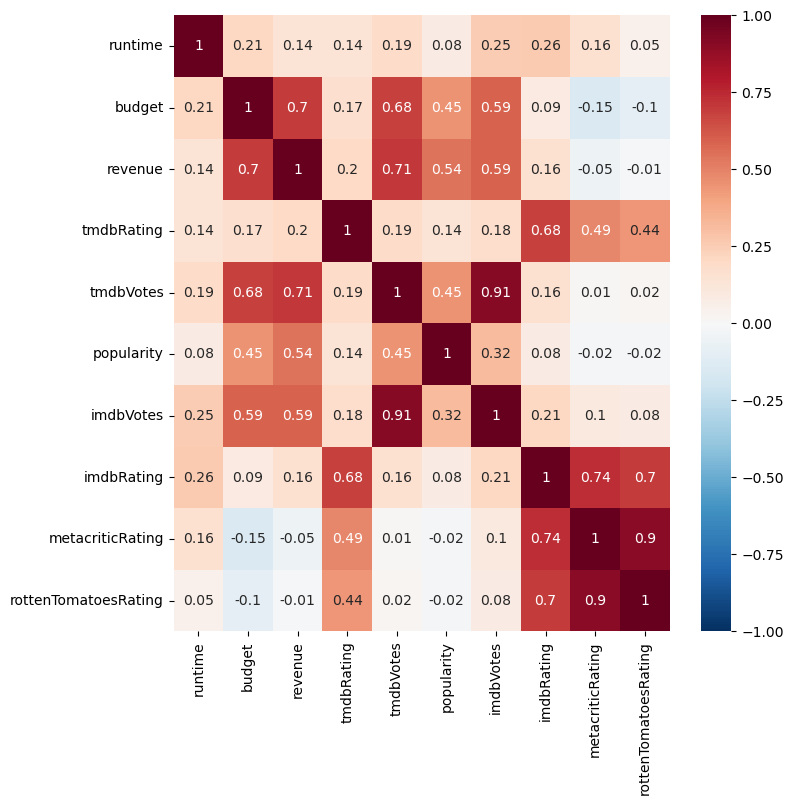

In [90]:
#Correlation Heatmap of numeric variables
fig1, ax1 = plt.subplots()
plt.rcParams["figure.figsize"] = (8,8)

sns.heatmap(movies_DB.corr(numeric_only=True).round(2), cmap = 'RdBu_r', annot = True, vmin = -1);

plt.savefig("./corr.svg", bbox_inches='tight')

In [91]:
#Counts of original language
movies_DB['originalLanguage'].value_counts()

originalLanguage
en    540
fr    112
es     83
it     33
ja     27
hi     20
zh     20
ko     19
pt     16
de     12
pl     10
ml      8
sv      7
ru      7
tr      7
nl      5
th      5
te      5
no      5
ta      4
ar      4
tl      3
da      3
cn      3
id      2
ca      2
ga      1
lv      1
uk      1
ka      1
is      1
fa      1
fi      1
pa      1
yo      1
xh      1
hr      1
xx      1
Name: count, dtype: int64

In [92]:
#Counts of original country - some have more than one country
orig_country = movies_DB['originCountry']
country_count = {}

for countries in orig_country:
    if countries:
        
        for country in countries:
            
            if country in country_count.keys():
                country_count[country] += 1
            
            else:
                country_count[country] = 1

pd.Series(country_count).sort_values(ascending=False)

US    437
FR    128
GB     74
ES     45
IT     45
IN     38
JP     30
MX     30
BE     25
CA     24
DE     19
KR     19
CN     18
AU     15
BR     15
AR     11
PL     10
SE     10
TR      7
RU      7
TH      6
IE      6
NO      6
DK      5
NL      5
NZ      5
CO      5
TW      5
ZA      4
NG      4
PH      3
HK      3
CL      3
IR      2
LU      2
DO      2
CH      2
UA      2
ID      2
GR      2
BG      1
XK      1
PT      1
CY      1
SA      1
GE      1
IS      1
FI      1
LB      1
KW      1
MR      1
CI      1
SK      1
AE      1
LV      1
PS      1
AT      1
PY      1
HR      1
dtype: int64

In [93]:
#Counts of genre - some have more than one genre
gen_res = movies_DB['genre']
genre_count = {}
for genres in gen_res:
    if genres is not np.nan:
        for genre in genres:
            if genre in genre_count.keys():
                genre_count[genre] += 1
            else:
                genre_count[genre] = 1

pd.Series(genre_count).sort_values(ascending=False)

Drama          416
Comedy         313
Thriller       200
Action         199
Horror         148
Crime          119
Adventure      113
Romance         89
Animation       78
Documentary     64
Mystery         58
Biography       55
Sci-Fi          44
History         41
Fantasy         39
Music           32
Short           28
Sport           25
Family          20
Western          6
War              6
Musical          5
dtype: int64

### 8.2 Visualizations

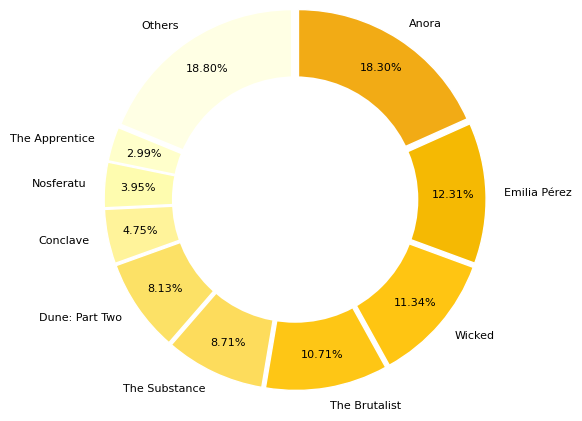

In [95]:
#Plotting a donut chart about mentions counts
fig2, ax2 = plt.subplots()
plt.rcParams["figure.figsize"] = (4,4)

viz_pie = counts_df[['title','mentionsCount']].sort_values(by=['mentionsCount'], ascending=True)

count = 0
for value in viz_pie['mentionsCount']:
    if value<230:
        count += value

others = pd.DataFrame({'title':'Others', 'mentionsCount':count},index = [0])
viz_pie = pd.concat([others,viz_pie], ignore_index=True)

viz_pie.drop(viz_pie[viz_pie['mentionsCount']<230].index, inplace=True)

pie_len = len(viz_pie['mentionsCount'])

colors = ['#ffffe4', '#ffffcb', '#fefcaf', '#fff39a', '#fce166', 
          '#fddc5c', '#fec615', '#ffc512', '#f5b903', '#f2ab15']

explode = [0.05 for i in range(10)]

plt.pie(viz_pie['mentionsCount'], radius=1.5, labels=viz_pie['title'], textprops={'fontsize':8},
       autopct='%1.2f%%', colors=colors, startangle=90, 
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=False, explode = explode, pctdistance=0.82,)

centre_circle = plt.Circle((0, 0), 1, fc='white')
fig = plt.gcf()
 
#Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

plt.savefig("./pie.svg", bbox_inches='tight')

plt.show()

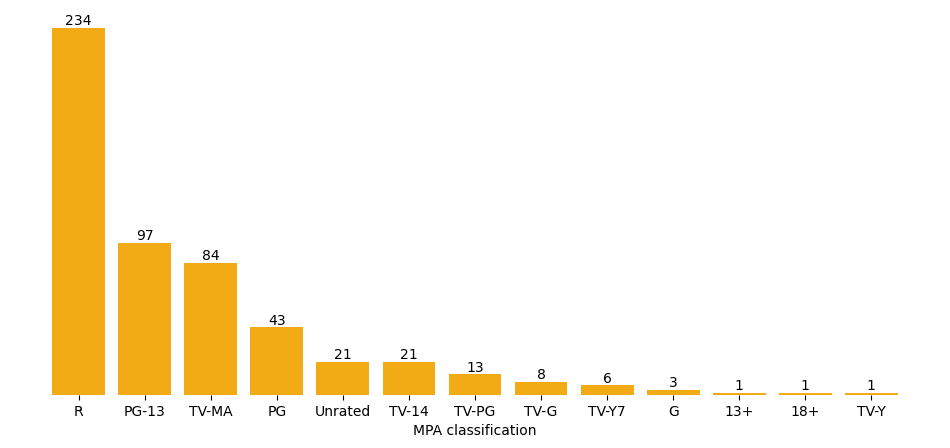

In [97]:
#Plotting a bar chart which counts movies for the MPA classification
viz_bar = pd.DataFrame(movies_DB['mpaFilmRating'].value_counts()).reset_index()

fig3, ax3 = plt.subplots()
plt.rcParams["figure.figsize"] = (12, 5)

bars = plt.bar(viz_bar['mpaFilmRating'], viz_bar['count'], color='#f2ab15', width = 0.8)

plt.xlabel('MPA classification')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}',
             ha='center', va='bottom')

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tick_params(left=False)

ax = plt.gca()
ax.get_yaxis().set_visible(False) 

plt.savefig("./bars.svg")

plt.show()

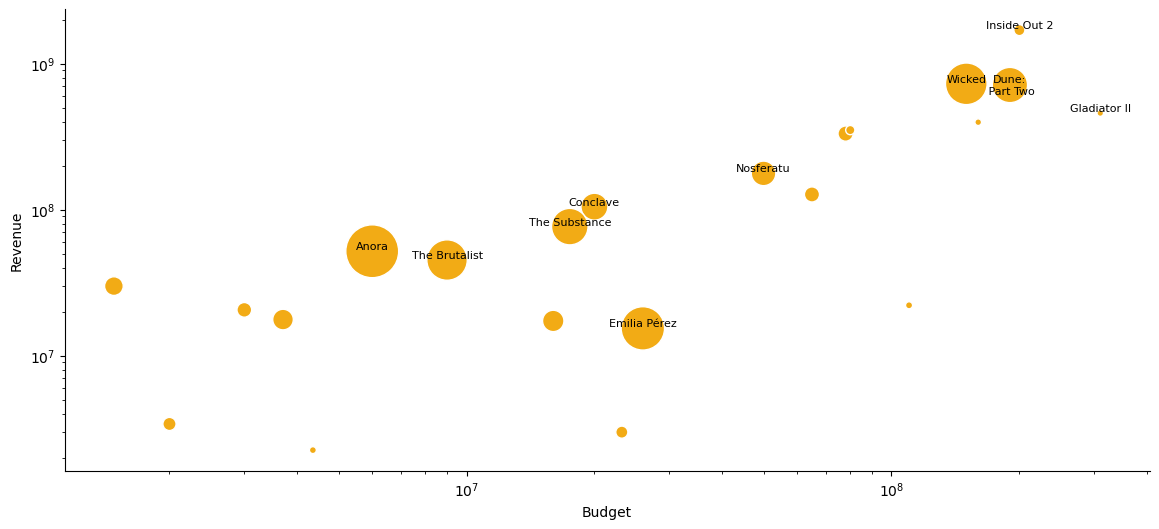

In [99]:
#Plotting a bubble chart comparing budget and revenue, ball sizes are related to the amount of comments for each movie
viz_bubble = counts_df.merge(movies_DB[['imdbID', 'revenue', 'budget']], on='imdbID', how='left')

fig4, ax4 = plt.subplots()
plt.rcParams["figure.figsize"] = (14,6)
plt.xscale("log")
plt.yscale("log")

x = viz_bubble['budget']
y = viz_bubble['revenue']
s = viz_bubble['mentionsCount']

plt.scatter(x=x, y=y, s=s, color='#f2ab15', edgecolors="w")

plt.xlabel('Budget')
plt.ylabel('Revenue')

texts = []

for i in range(len(viz_bubble)):
    
        if viz_bubble['mentionsCount'][i] > 300 or viz_bubble['revenue'][i] > 4e8 or viz_bubble['budget'][i] > 4e8:
    
            if viz_bubble['title'][i]=='Dune: Part Two':
                text = plt.text(x[i], y[i], 'Dune:\n Part Two', fontsize=8, ha='center', va='center')
                texts.append(text)
            else: 
                text = plt.text(x[i], y[i], viz_bubble['title'][i], fontsize=8, ha='center', va='bottom')
                texts.append(text)


plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.savefig("./bubbles.svg")

plt.show()

## 9. Data Storage

In [100]:
movies_DB.to_csv(r".\movies_DB.csv", index=False)
counts_df.to_csv(r".\counts_df.csv", index=False)
oscars_df.to_csv(r".\oscars_df.csv", index=False)